# Figure 2: PCA residuals with fake planets

## 1. Imports

In [43]:
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
color_map = cmocean.cm.ice

from applefy.utils.file_handling import load_adi_data
from applefy.utils.fake_planets import add_fake_planets
from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest
from applefy.utils import mag2flux_ratio

from fours.utils.pca import pca_psf_subtraction_gpu
from fours.utils.data_handling import read_fours_root_dir

## 2. Load the dataset

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"
root_dir = Path(read_fours_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [4]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [5]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")

In [6]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [7]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [8]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

## 3. Add fake planets with applefy

In [46]:
# 3 lambda / D, 9 mag
fake_planet_config_1 = {
    'type': 'TP estimation',
    'flux_ratio': mag2flux_ratio(9.5),
    'separation': 10.8,
    'planet_position': (
        39.6, 35.646925639128064, 10.8, 240),
    'exp_id': 'x1'}

# 10 lambda / D, 12.5 mag
fake_planet_config_2 = {
    'type': 'TP estimation',
    'flux_ratio': mag2flux_ratio(12.5),
    'separation': 36.00000000000001,
    'planet_position': (
        81.0, 45.0, 36.00000000000001, 0.0),
    'exp_id': 'x2'}

In [47]:
# add the first planet
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template,
    parang=angles,
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    experiment_config=fake_planet_config_1,
    scaling_factor=scaling_factor)

# add the second planet
data_with_fake_planet = add_fake_planets(
    input_stack=data_with_fake_planet,
    psf_template=psf_template,
    parang=angles,
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    experiment_config=fake_planet_config_2,
    scaling_factor=scaling_factor)

## 4. Compute the residuals

In [48]:
pca_numbers = np.concatenate(
    [np.arange(0, 30, 2)[1:],
     np.arange(30, 100, 10),
     np.arange(100, 200, 20),
     np.arange(200, 550, 50)])

In [70]:
pca_numbers = np.arange(0, 500, 5)[1:]

In [71]:
pca_residuals = pca_psf_subtraction_gpu(
    images=data_with_fake_planet,
    angles=angles,
    pca_numbers=pca_numbers,
    device=0,
    verbose=True,
    combine="mean")

Compute PCA basis ...[DONE]
Compute PCA residuals ...[DONE]


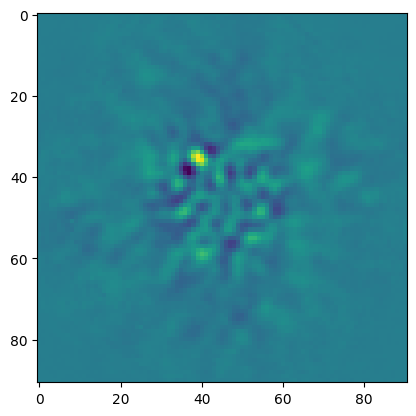

In [72]:
plt.imshow(pca_residuals[np.where(pca_numbers==40)[0][0]])

## 5. Compute the S/N

In [73]:
photometry_mode_planet = AperturePhotometryMode("AS", search_area=0.5, psf_fwhm_radius=fwhm/2)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=fwhm/2)

In [74]:
def compute_snr(config_in):
    all_snr_pca = []
    for i in tqdm(range(len(pca_numbers))):
        _, _, snr_mean = compute_detection_uncertainty(
            frame=pca_residuals[i],
            planet_position=config_in["planet_position"], 
            statistical_test=TTest(),
            psf_fwhm_radius=fwhm,
            photometry_mode_planet=photometry_mode_planet,
            photometry_mode_noise=photometry_mode_noise,
            safety_margin=2.,
            num_rot_iter=20)

        all_snr_pca.append(np.round(np.mean(snr_mean), 1))
        
    return np.array(all_snr_pca)

In [75]:
snr_pca_1 = compute_snr(fake_planet_config_1)
snr_pca_2 = compute_snr(fake_planet_config_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [03:33<00:00,  2.16s/it]


Text(0, 0.5, 'S/N')

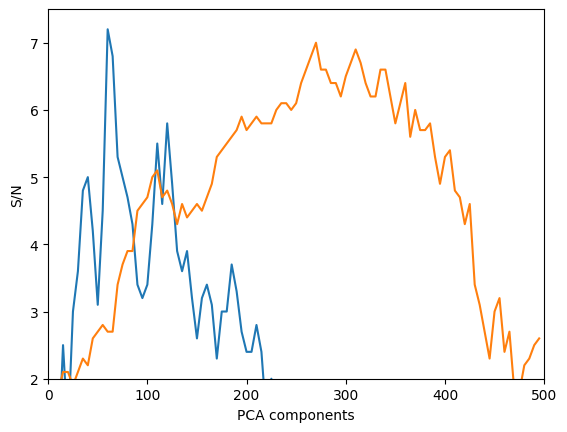

In [76]:
plt.plot(pca_numbers, snr_pca_1)
plt.plot(pca_numbers, snr_pca_2)
plt.ylim(2, 7.5)
plt.xlim(0, 500)
plt.xlabel("PCA components")
plt.ylabel("S/N")

In [93]:
pca_numbers[np.argmax(snr_pca_1)]

60

## 5. Plot the results

In [77]:
def add_colorbar(axis_in, plot_in, left=True):
    if left:
        tick_side = "left"
    else:
        tick_side = "right"
        
    divider = make_axes_locatable(axis_in)
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=left)
    fig.add_axes(cax)
    
    cbar = fig.colorbar(plot_in, cax=cax, 
                 orientation="horizontal")
    cbar.ax.yaxis.set_ticks_position(tick_side)
    cbar.ax.tick_params(labelsize=10)

In [149]:
def show_residual(axis_in, residual_image, color_range):
    # plot the image
    plot1 = axis_in.imshow(
        residual_image, 
        cmap=color_map, origin='lower',
        vmin=color_range[0], vmax=color_range[1])
    
    add_colorbar(axis_in, plot1, True)
    
    # inner planet
    axis_in.scatter(
        *np.array(fake_planet_config_2["planet_position"])[:2],
        c='none',
        edgecolor="w",
        linestyle="dashed",
        marker='o',
        alpha=0.5, lw=1,
        s=150)
    
    # outer plannet
    axis_in.scatter(
        *np.array(fake_planet_config_1["planet_position"])[:2],
        c='none',
        edgecolor="w",
        linestyle="-",
        marker='o',
        alpha=0.5, lw=1,
        s=150)
    
    axis_in.set_xticks([]) 
    axis_in.set_yticks([]) 

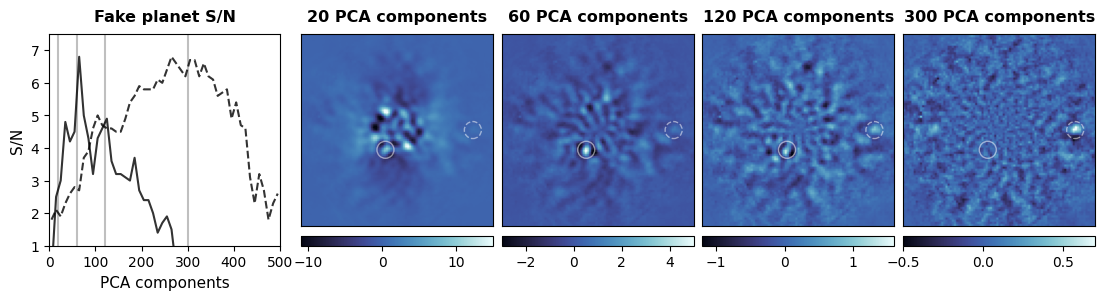

In [156]:
fig = plt.figure(constrained_layout=False, figsize=(13.5, 2.75))
gs0 = fig.add_gridspec(1, 6, hspace=0.05, wspace=0.05, 
                       width_ratios=[1.2, 0.02, 1, 1, 1, 1])

pca_idx = [np.where(pca_numbers==20)[0][0],
           np.where(pca_numbers==60)[0][0],
           np.where(pca_numbers==120)[0][0],
           np.where(pca_numbers==300)[0][0]]

axis_pca_1 = fig.add_subplot(gs0[2])
axis_pca_2 = fig.add_subplot(gs0[3])
axis_pca_3 = fig.add_subplot(gs0[4])
axis_pca_4 = fig.add_subplot(gs0[5])

axis_snr = fig.add_subplot(gs0[0])

# PCA Residuals -----------------
show_residual(axis_pca_1, pca_residuals[pca_idx[0]], (-11, 15))
show_residual(axis_pca_2, pca_residuals[pca_idx[1]], (-3, 5))
show_residual(axis_pca_3, pca_residuals[pca_idx[2]], (-1.2, 1.6))
show_residual(axis_pca_4, pca_residuals[pca_idx[3]], (-0.5, 0.7)) 
    
# Plot the S/N curves -----------------
axis_snr.vlines([20, 60, 120, 300], 0, 7.5, color="grey", alpha=0.5)
axis_snr.plot(pca_numbers[::2], snr_pca_1[::2], label="$3 \lambda / D$, $9.5$ mag",
              color="black", ls="-", lw=1.5, alpha=0.8)
axis_snr.plot(pca_numbers[::2], snr_pca_2[::2], label="$10 \lambda / D$, $12.5$ mag",
              color="black", ls="dashed", lw=1.5, alpha=0.8)

axis_snr.set_ylim(1, 7.5)
axis_snr.set_xlim(0, 500)
axis_snr.set_xlabel("PCA components", fontsize=11)
axis_snr.set_ylabel("S/N", fontsize=11) 
axis_snr.set_title(
    "Fake planet S/N", fontsize=11.5, 
    fontweight="bold", y=1.02)

#axis_snr.legend(
#    framealpha=1,
#    loc='upper center', bbox_to_anchor=(0.5, 0.3),
#    prop={'size': 10},
#    ncol=1)


# Titles -----------------
#axis_pca_1.set_ylabel(
#    "Fake planets at \n ($3 \lambda / D$, $9$ mag) \n ($10 \lambda / D$, $12.5$ mag)",
#    fontsize=13)

axis_pca_1.set_title(
    str(pca_numbers[pca_idx][0]) + " PCA components", fontsize=11.5, 
    fontweight="bold", y=1.02)

axis_pca_2.set_title(
    str(pca_numbers[pca_idx][1]) + " PCA components", fontsize=11.5, 
    fontweight="bold", y=1.02)

axis_pca_3.set_title(
    str(pca_numbers[pca_idx][2]) + " PCA components", fontsize=11.5, 
    fontweight="bold", y=1.02)

axis_pca_4.set_title(
    str(pca_numbers[pca_idx][3]) + " PCA components", fontsize=11.5, 
    fontweight="bold", y=1.02)

# Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/02_pca_residuals.pdf", bbox_inches='tight')